Суть проекта — подготовить датасет на основе данных, полученных путем SQL запросов к базе данных (БД) об авиарейсах по России из открытого источника, и на основании их провести разведывательный анализ, а также составить отчёт по его результатам.

Для анализа берется информация об авиарейсах из города Анапа в зимнее время за 2017 год.

Существует следующая проблема: не все рейсы из города Анапа окупаются в "низкий сезон". При этом есть потенциально прибыльные направления, но у компании не хватает самолетов для их запуска.

Отсюда ставится задача:
Отследить малоприбыльные рейсы, от которых впоследствии можно отказаться, либо предложить иные пути увеличения прибыльности.

Мы будем использовать самую простую модель оценки прибыльности: \
"Доход от продажи билетов - Расходы на топливо" в разрезе рейса. 

Расходы на авиаГСМ рассчитываются по уравнению вида: 

Э = (С*Q/1000)*T,

Где С - стоимость 1 тонны топлива, руб./т; \
Q - среднечасовой расход топлива, кг/ч; \
T - длительность полета, ч.

Ссылки на внешние источники данных:
1) ЦЕНЫ НА АВИАГСМ: \
https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/ \
2) Часовой расход топлива (кг/ч) для модели BOEING 737-300: \
https://www.airlines-inform.ru/commercial-aircraft/boeing-737-300.html \
3) Часовой расход топлива (кг/ч) для модели Sukhoi Superjet-100: \
https://www.rbc.ru/economics/26/10/2010/5703dfc19a79473c0df1619a

Для начала ознакомимся с БД (ссылка на источник: https://postgrespro.ru/docs/postgrespro/10/demodb-bookings):

In [1]:
# ДИАГРАММА СХЕМЫ ДАННЫХ

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://postgrespro.ru/media/docs/postgrespro/10/ru/demodb-bookings-schema.svg")

ОПИСАНИЕ СХЕМЫ

Основной сущностью является таблица бронирований (bookings).

В одно бронирование можно включить несколько пассажиров, каждому из которых выписывается отдельный билет (tickets). Билет имеет уникальный номер и содержит информацию о пассажире. Как таковой пассажир не является отдельной сущностью. Как имя, так и номер документа пассажира могут меняться с течением времени, так что невозможно однозначно найти все билеты одного человека; для простоты можно считать, что все пассажиры уникальны.

Билет включает один или несколько перелетов (ticket_flights). Несколько перелетов могут входить в билет в случаях, когда нет прямого рейса, соединяющего пункты отправления и назначения (полёт с пересадками), либо когда билет взят «туда и обратно». В схеме данных нет жёсткого ограничения, но предполагается, что все билеты в одном бронировании имеют одинаковый набор перелетов.

Каждый рейс (flights) следует из одного аэропорта (airports) в другой. Рейсы с одним номером имеют одинаковые пункты вылета и назначения, но будут отличаться датой отправления.

При регистрации на рейс пассажиру выдаётся посадочный талон (boarding_passes), в котором указано место в самолете. Пассажир может зарегистрироваться только на тот рейс, который есть у него в билете. Комбинация рейса и места в самолете должна быть уникальной, чтобы не допустить выдачу двух посадочных талонов на одно место.

Количество мест (seats) в самолете и их распределение по классам обслуживания зависит от модели самолета (aircrafts), выполняющего рейс. Предполагается, что каждая модель самолета имеет только одну компоновку салона. Схема данных не контролирует, что места в посадочных талонах соответствуют имеющимся в самолете (такая проверка может быть сделана с использованием табличных триггеров или в приложении).

Приступим к изучению датасета, сформированного на основании SQL запросов к БД

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

flight = pd.read_csv('project_4_flights.csv')

Рассмотрим, какие данные хранятся в файле. Ознакомимся с типом данных у столбцов:

In [3]:
flight.sample(10)

,flight_id,flight_no,city_depart,city_arrive,scheduled_departure,scheduled_arrival,fl_month,flight_minute,model,class_available,seat_available,ticket_no,class_occupied,seat_occupied,ticket_price
1055,136159,PG0252,Anapa,Moscow,2017-01-04T10:05:00Z,2017-01-04T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,7A,5.432333e+09,Economy,7A,12200.0
6457,136439,PG0252,Anapa,Moscow,2017-02-25T10:05:00Z,2017-02-25T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,11C,5.434148e+09,Economy,11C,13400.0
10169,136660,PG0480,Anapa,Belgorod,2017-02-20T09:25:00Z,2017-02-20T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,19D,5.432376e+09,Economy,19D,6300.0
951,136146,PG0252,Anapa,Moscow,2017-02-09T10:05:00Z,2017-02-09T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,15B,5.432351e+09,Economy,15B,12200.0
10559,136672,PG0480,Anapa,Belgorod,2017-02-03T09:25:00Z,2017-02-03T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,18A,5.432376e+09,Economy,18A,6300.0
694,136132,PG0252,Anapa,Moscow,2017-02-15T10:05:00Z,2017-02-15T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,11B,5.432352e+09,Economy,11B,13400.0
8270,136540,PG0194,Anapa,Novokuznetsk,2017-01-17T06:10:00Z,2017-01-17T11:15:00Z,1.0,305.0,Boeing 737-300,Economy,5B,NaN,NaN,NaN,NaN
13252,136869,PG0480,Anapa,Belgorod,2017-01-31T09:25:00Z,2017-01-31T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Economy,13A,5.432320e+09,Economy,13A,6300.0
3088,136266,PG0252,Anapa,Moscow,2017-02-27T10:05:00Z,2017-02-27T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,20F,5.435173e+09,Economy,20F,12200.0
1070,136159,PG0252,Anapa,Moscow,2017-01-04T10:05:00Z,2017-01-04T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,4A,5.432349e+09,Economy,4A,12200.0


In [4]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14563 entries, 0 to 14562
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            14563 non-null  int64  
 1   flight_no            14563 non-null  object 
 2   city_depart          14563 non-null  object 
 3   city_arrive          14563 non-null  object 
 4   scheduled_departure  14563 non-null  object 
 5   scheduled_arrival    14563 non-null  object 
 6   fl_month             14563 non-null  float64
 7   flight_minute        14563 non-null  float64
 8   model                14563 non-null  object 
 9   class_available      14563 non-null  object 
 10  seat_available       14563 non-null  object 
 11  ticket_no            11995 non-null  float64
 12  class_occupied       11995 non-null  object 
 13  seat_occupied        11995 non-null  object 
 14  ticket_price         11995 non-null  float64
dtypes: float64(4), int64(1), object(10)


Датасет содержит 5 числовых и 10 строковых столбцов. Имеются столбцы с отсутствующими значениями. Они будут использованы для дальнейшего анализа.

Подробнее по признакам:

flight_id: Идентификатор (ID) рейса \
flight_no: Номер рейса \
city_depart: Город отправления \
city_arrive: Город прибытия \
scheduled_departure: Время вылета по расписанию \
scheduled_arrival: Время прилета по расписанию \
fl_month: Номер месяца перелета \
flight_minute: Время полета в минутах \
model: Модель самолета \
class_available: Класс обслуживания (по схеме борта) \
seat_available: Номер места (все места борта) \
ticket_no: Номер билета \
class_occupied: Класс обслуживания по проданному билету \
seat_occupied: Номер проданного места \
ticket_price: Стоимость билета

In [5]:
def unique_col(column):   # функция для подсчета уникальных значений
    print('столбец {}:'.format(column))
    return flight[column].unique(), \
    'количество уникальных значений - {}'.format(flight[column].nunique())


def fill_ticket_price(row):  # функция для заполнения колонки "ticket_price"
    if row.model == 'Boeing 737-300':
        if row.class_available == 'Business':
            return 36600
        elif row.class_available == 'Economy' \
        and row.seat_available in ['11E', '11A', '11C', '11B', '11F', '11D']:
            return 13400
        else:
            return 12200
    else:
        if row.class_available == 'Business':
            return 18900
        elif row.class_available == 'Economy' \
        and row.seat_available in ['6A', '6C', '6F', '6E', '6D']:
            return 6900
        else:
            return 6300

In [6]:
# отформатируем значение колонки, приведем к целому числу
flight['ticket_no'] = flight['ticket_no'].apply(lambda x: "{:.0f}".format(x))

In [7]:
flight['ticket_no'].value_counts().sort_values()

5432319272       1
5432375050       1
5432375087       1
5432376612       1
5435171558       1
              ... 
5432375396       1
5435171187       1
5432376028       1
5432374790       1
nan           2568
Name: ticket_no, Length: 11996, dtype: int64

Как видим, имеются пустые значения в столбце 'ticket_no'. Они нам понадобятся в дальнейшем для оценки максимально возможной прибыли, при полной заполненности рейса. 

Ознакомимся с уникальными значениями, содержащимися в каждом столбце. Применим функцию unique_col(column):

In [8]:
for col in flight.columns:
    display(unique_col(col))

столбец flight_id:


(array([136119, 136120, 136122, 136130, 136131, 136132, 136135, 136146,
        136159, 136164, 136165, 136172, 136178, 136181, 136185, 136202,
        136204, 136209, 136215, 136226, 136249, 136250, 136264, 136266,
        136268, 136269, 136270, 136275, 136282, 136284, 136293, 136310,
        136316, 136320, 136322, 136345, 136348, 136351, 136360, 136366,
        136383, 136387, 136389, 136403, 136411, 136420, 136423, 136428,
        136436, 136439, 136441, 136452, 136458, 136463, 136464, 136471,
        136479, 136485, 136486, 136511, 136513, 136514, 136523, 136540,
        136544, 136546, 136560, 136567, 136571, 136586, 136600, 136605,
        136609, 136612, 136620, 136630, 136632, 136642, 136645, 136649,
        136654, 136660, 136661, 136666, 136669, 136672, 136678, 136706,
        136709, 136720, 136729, 136733, 136754, 136755, 136757, 136758,
        136767, 136769, 136778, 136780, 136781, 136802, 136807, 136815,
        136819, 136823, 136827, 136838, 136841, 136844, 136855, 

столбец flight_no:


(array(['PG0252', 'PG0194', 'PG0480'], dtype=object),
 'количество уникальных значений - 3')

столбец city_depart:


(array(['Anapa'], dtype=object), 'количество уникальных значений - 1')

столбец city_arrive:


(array(['Moscow', 'Novokuznetsk', 'Belgorod'], dtype=object),
 'количество уникальных значений - 3')

столбец scheduled_departure:


(array(['2017-01-03T10:05:00Z', '2017-02-24T10:05:00Z',
        '2017-01-08T10:05:00Z', '2017-02-13T10:05:00Z',
        '2017-01-28T10:05:00Z', '2017-02-15T10:05:00Z',
        '2017-02-01T10:05:00Z', '2017-02-09T10:05:00Z',
        '2017-01-04T10:05:00Z', '2017-01-07T10:05:00Z',
        '2017-02-22T10:05:00Z', '2017-01-15T10:05:00Z',
        '2017-01-29T10:05:00Z', '2017-01-31T10:05:00Z',
        '2017-01-14T10:05:00Z', '2017-01-05T10:05:00Z',
        '2017-02-23T10:05:00Z', '2017-01-06T10:05:00Z',
        '2017-02-28T10:05:00Z', '2017-01-30T10:05:00Z',
        '2017-02-14T10:05:00Z', '2017-02-08T10:05:00Z',
        '2017-02-18T10:05:00Z', '2017-02-27T10:05:00Z',
        '2017-02-16T10:05:00Z', '2017-02-11T10:05:00Z',
        '2017-02-12T10:05:00Z', '2017-01-13T10:05:00Z',
        '2017-01-16T10:05:00Z', '2017-02-07T10:05:00Z',
        '2017-01-23T10:05:00Z', '2017-01-22T10:05:00Z',
        '2017-01-12T10:05:00Z', '2017-02-19T10:05:00Z',
        '2017-02-06T10:05:00Z', '2017-01-24T10:0

столбец scheduled_arrival:


(array(['2017-01-03T11:45:00Z', '2017-02-24T11:45:00Z',
        '2017-01-08T11:45:00Z', '2017-02-13T11:45:00Z',
        '2017-01-28T11:45:00Z', '2017-02-15T11:45:00Z',
        '2017-02-01T11:45:00Z', '2017-02-09T11:45:00Z',
        '2017-01-04T11:45:00Z', '2017-01-07T11:45:00Z',
        '2017-02-22T11:45:00Z', '2017-01-15T11:45:00Z',
        '2017-01-29T11:45:00Z', '2017-01-31T11:45:00Z',
        '2017-01-14T11:45:00Z', '2017-01-05T11:45:00Z',
        '2017-02-23T11:45:00Z', '2017-01-06T11:45:00Z',
        '2017-02-28T11:45:00Z', '2017-01-30T11:45:00Z',
        '2017-02-14T11:45:00Z', '2017-02-08T11:45:00Z',
        '2017-02-18T11:45:00Z', '2017-02-27T11:45:00Z',
        '2017-02-16T11:45:00Z', '2017-02-11T11:45:00Z',
        '2017-02-12T11:45:00Z', '2017-01-13T11:45:00Z',
        '2017-01-16T11:45:00Z', '2017-02-07T11:45:00Z',
        '2017-01-23T11:45:00Z', '2017-01-22T11:45:00Z',
        '2017-01-12T11:45:00Z', '2017-02-19T11:45:00Z',
        '2017-02-06T11:45:00Z', '2017-01-24T11:4

столбец fl_month:


(array([1., 2.]), 'количество уникальных значений - 2')

столбец flight_minute:


(array([100., 305.,  50.]), 'количество уникальных значений - 3')

столбец model:


(array(['Boeing 737-300', 'Sukhoi Superjet-100'], dtype=object),
 'количество уникальных значений - 2')

столбец class_available:


(array(['Business', 'Economy'], dtype=object),
 'количество уникальных значений - 2')

столбец seat_available:


(array(['3A', '1F', '3D', '1D', '1C', '2D', '1A', '3C', '2C', '2F', '2A',
        '3F', '9B', '15D', '10D', '5A', '6E', '17A', '11E', '11A', '7B',
        '16F', '7E', '17D', '14E', '21C', '6D', '17F', '23F', '8D', '12D',
        '21F', '15B', '4E', '15E', '10C', '4B', '4F', '7F', '9C', '13F',
        '12A', '18A', '6A', '11C', '21A', '7C', '7A', '20F', '4C', '9F',
        '9D', '14F', '22F', '22A', '8E', '19B', '16E', '14B', '20E', '8C',
        '16C', '21D', '12C', '9E', '6B', '13D', '18E', '12B', '18C', '5E',
        '8A', '16B', '5B', '15F', '20B', '17C', '22B', '16D', '14D', '19C',
        '13B', '4D', '22E', '17E', '17B', '6F', '6C', '22C', '14A', '13C',
        '20D', '22D', '5F', '7D', '11B', '5D', '13E', '20C', '11F', '23B',
        '23E', '13A', '18D', '10E', '23A', '19F', '5C', '18F', '19D',
        '16A', '19E', '8B', '15C', '20A', '12F', '8F', '12E', '10B', '9A',
        '21B', '23C', '18B', '21E', '4A', '15A', '23D', '11D', '14C',
        '19A', '10F', '10A'], dtype=objec

столбец ticket_no:


(array(['5432333357', '5432349514', '5432349550', ..., '5432375774',
        '5432375784', '5432375785'], dtype=object),
 'количество уникальных значений - 11996')

столбец class_occupied:


(array(['Business', nan, 'Economy'], dtype=object),
 'количество уникальных значений - 2')

столбец seat_occupied:


(array(['3A', '1F', '3D', '1D', '1C', '2D', '1A', '3C', '2C', '2F', '2A',
        nan, '9B', '15D', '10D', '5A', '6E', '17A', '11E', '11A', '7B',
        '16F', '7E', '17D', '14E', '21C', '6D', '17F', '23F', '8D', '12D',
        '21F', '15B', '4E', '15E', '10C', '4B', '4F', '7F', '9C', '13F',
        '12A', '18A', '6A', '11C', '21A', '7C', '7A', '20F', '4C', '9F',
        '9D', '14F', '22F', '22A', '8E', '19B', '16E', '14B', '20E', '8C',
        '16C', '21D', '12C', '9E', '6B', '13D', '18E', '12B', '18C', '5E',
        '8A', '16B', '5B', '15F', '20B', '17C', '22B', '16D', '14D', '19C',
        '13B', '4D', '22E', '17E', '17B', '6F', '6C', '22C', '14A', '13C',
        '20D', '22D', '5F', '7D', '11B', '5D', '13E', '20C', '11F', '23B',
        '23E', '13A', '18D', '10E', '23A', '19F', '5C', '18F', '19D',
        '16A', '19E', '8B', '15C', '3F', '23D', '4A', '14C', '23C', '12F',
        '9A', '21E', '20A', '10B', '12E', '8F', '15A', '11D', '18B', '21B',
        '19A', '10F', '10A'], dtype=

столбец ticket_price:


(array([36600.,    nan, 12200., 13400., 18900.,  6300.,  6900.]),
 'количество уникальных значений - 6')

Можно сделать предварительные выводы:

1) Всего в датасете содержится информация о 127-ми рейсах, совершенных зимой 2017 года из г. Анапа \
2) Существует 3 направления, по которым запущено всего 3 борта самолета по одному на каждое: \
Анапа-Москва, Анапа-Новокузнецк и Анапа-Белгород \
3) В датасете отсутствуют данные по декабрю 2017 г. \
4) Время в пути для 3-х направлений: 100 минут, 305 мин. и 50 мин. \
5) Представлено 2 модели самолетов по указанным направлениям: Boeing 737-300 и Sukhoi Superjet-100 \
6) На каждом самолете представлено всего 2 класса обслуживания: Бизнес и Эконом \
7) Также имеется информация по проданным на каждый рейс местам определенного класса обслуживания с соответсвующей стоимостью билета

In [9]:
# Создадим 2 словаря
fuel_tarif = pd.DataFrame({'fl_month': [1, 2],              # данные о тарифах на авиаГСМ
                      'fuel_price': [48893.30, 46672.54]})

aircraft_model = pd.DataFrame({'model': ['Boeing 737-300', 'Sukhoi Superjet-100'],   # среднечасовой расход топлива
                      'fuel_per_hour': [2600, 1800]})

In [10]:
fuel_tarif

,fl_month,fuel_price
0,1,48893.30
1,2,46672.54


In [11]:
aircraft_model

,model,fuel_per_hour
0,Boeing 737-300,2600
1,Sukhoi Superjet-100,1800


In [12]:
# Объединим данные словари с датасетом
flight = flight.merge(fuel_tarif, on = 'fl_month', how = 'inner')
flight = flight.merge(aircraft_model, on = 'model', how = 'inner')

In [13]:
flight.sample(5)

,flight_id,flight_no,city_depart,city_arrive,scheduled_departure,scheduled_arrival,fl_month,flight_minute,model,class_available,seat_available,ticket_no,class_occupied,seat_occupied,ticket_price,fuel_price,fuel_per_hour
9837,136678,PG0480,Anapa,Belgorod,2017-01-28T09:25:00Z,2017-01-28T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Economy,7E,5432319504,Economy,7E,6300.0,48893.30,1800
840,136178,PG0252,Anapa,Moscow,2017-01-29T10:05:00Z,2017-01-29T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,21D,5432362762,Economy,21D,12200.0,48893.30,2600
9762,136669,PG0480,Anapa,Belgorod,2017-01-17T09:25:00Z,2017-01-17T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Economy,18D,5432319182,Economy,18D,6300.0,48893.30,1800
6746,136284,PG0252,Anapa,Moscow,2017-02-07T10:05:00Z,2017-02-07T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,20F,5435489607,Economy,20F,12200.0,46672.54,2600
10674,136758,PG0480,Anapa,Belgorod,2017-01-12T09:25:00Z,2017-01-12T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Economy,7F,5432374727,Economy,7F,6300.0,48893.30,1800


In [14]:
# Добавим столбец 'fl_day' - номер дня в датасет
flight['scheduled_departure'] = pd.to_datetime(flight.scheduled_departure)
flight['fl_day'] = flight['scheduled_departure'].dt.day

In [15]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14563 entries, 0 to 14562
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   flight_id            14563 non-null  int64              
 1   flight_no            14563 non-null  object             
 2   city_depart          14563 non-null  object             
 3   city_arrive          14563 non-null  object             
 4   scheduled_departure  14563 non-null  datetime64[ns, UTC]
 5   scheduled_arrival    14563 non-null  object             
 6   fl_month             14563 non-null  float64            
 7   flight_minute        14563 non-null  float64            
 8   model                14563 non-null  object             
 9   class_available      14563 non-null  object             
 10  seat_available       14563 non-null  object             
 11  ticket_no            14563 non-null  object             
 12  class_occupied    

Изучим колонки с пустыми значениями. Для анализа наполняемости авиаборта, мы специально оставили пустые значения. Они содержатся в следующих столбцах:
1. class_occupied - класс обслуживания по проданному билету,
2. seat_occupied - номер проданного места,
3. ticket_price - стоимость билета (будет отсутствовать по непроданным местам),
4. ticket_no - номер билета (после форматирования принял значение nan).

Изучим интересные для анализа колонки. \
Произведем группировку данных для каждой модели по ID рейса и классу обслуживания, доступному для покупки:

In [16]:
model_scheme = flight.groupby(['flight_id', 'fl_day', 'model', 'class_available']) \
                            [['seat_available', 'seat_occupied']].count()
display(model_scheme.head(2), model_scheme.tail(2))

seat_available  seat_occupied
flight_id fl_day model          class_available                               
136119    3      Boeing 737-300 Business                     12             11
                                Economy                     118            102

seat_available  \
flight_id fl_day model               class_available                   
136956    4      Sukhoi Superjet-100 Business                     12   
                                     Economy                      85   

                                                      seat_occupied  
flight_id fl_day model               class_available                 
136956    4      Sukhoi Superjet-100 Business                    11  
                                     Economy                     85

Из таблицы следует, что количество доступных мест для каждой модели:

1) Boeing 737-300 - 12 мест в Бизнес-классе, 118 мест в Эконом-классе \
2) Sukhoi Superjet-100 - 12 мест в Бизнес-классе, 85 мест в Эконом-классе

В столбце "seat_occupied" можно проследить, сколько фактически было занято мест в каждом классе обслуживания по каждому рейсу.

Далее рассмотрим распределение количества всех мест на борту каждой модели самолета, а также занятых мест после покупки билета \
( в разрезе дня, месяца и модели)

In [17]:
flight_seat = flight.groupby(['fl_month', 'fl_day', 'model'])[['seat_available', 'seat_occupied']].count()

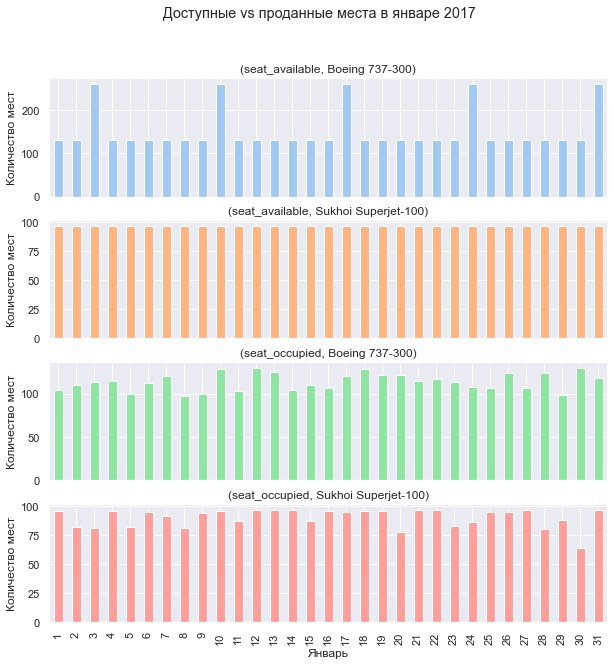

In [18]:
sns.set_theme(palette="pastel")
flight_seat.loc[1][:].unstack(1).plot(kind='bar', title = 'Доступные vs проданные места в январе 2017',\
                                      legend = False, figsize=(10,10), subplots=True,\
                                     xlabel="Январь", ylabel="Количество мест")
plt.show()

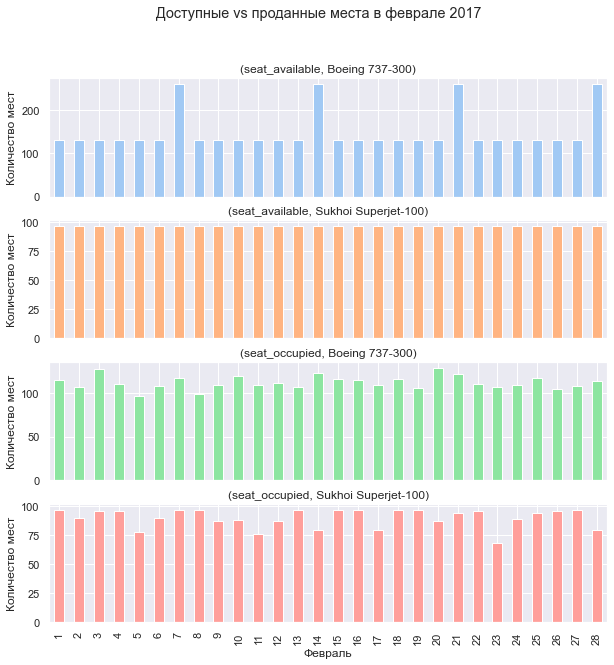

In [19]:
flight_seat.loc[2][:].unstack(1).plot(kind='bar', title = 'Доступные vs проданные места в феврале 2017',\
                                      legend = False, figsize=(10,10), subplots=True,\
                                     xlabel="Февраль", ylabel="Количество мест")
plt.show()

Можно заметить, что в определенные дни борт самолета Boeing 737-300 совершал два полета (предоставляя 260 мест), однако заполняемость в разрезе каждого дня не выходила за рамки 150 мест. Возможно, что именно в эти дни один из рейсов мог оказаться малоприбыльным. 

Далее посмотрим на суммарную выручку с продажи билетов по каждому номеру рейса:

In [20]:
ticket_price_for_class = flight.pivot_table(columns = 'class_available', index = 'flight_no', \
                                            values = 'ticket_price', aggfunc = 'sum')
ticket_price_for_class

class_available,Business,Economy
flight_no,,
PG0194,0.0,0.0
PG0252,22692000.0,74220000.0
PG0480,12341700.0,29574000.0


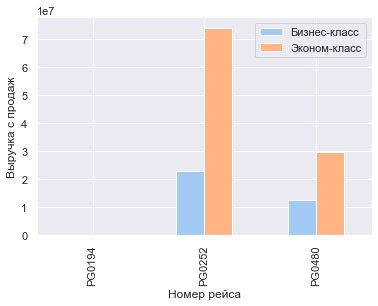

In [21]:
ticket_price_for_class.plot(kind='bar', xlabel="Номер рейса", ylabel="Выручка с продаж")
plt.legend(["Бизнес-класс", "Эконом-класс"])
plt.show()

In [22]:
flight[flight.flight_no == 'PG0194'].loc[:, ['city_depart', 'city_arrive']].value_counts()

city_depart  city_arrive 
Anapa        Novokuznetsk    1170
dtype: int64

Мы обнаружили, что данные по стоимости билетов по направлению Анапа-Новокузнецк (номер рейса PG0194) отсутствуют в нашем датасете. Удалим его из анализа, преобразуем датасет:

In [23]:
flight = flight[flight.flight_no != 'PG0194']
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13393 entries, 0 to 14562
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   flight_id            13393 non-null  int64              
 1   flight_no            13393 non-null  object             
 2   city_depart          13393 non-null  object             
 3   city_arrive          13393 non-null  object             
 4   scheduled_departure  13393 non-null  datetime64[ns, UTC]
 5   scheduled_arrival    13393 non-null  object             
 6   fl_month             13393 non-null  float64            
 7   flight_minute        13393 non-null  float64            
 8   model                13393 non-null  object             
 9   class_available      13393 non-null  object             
 10  seat_available       13393 non-null  object             
 11  ticket_no            13393 non-null  object             
 12  class_occupied    

Теперь изучим стоимость билета по каждой модели самолета и каждому классу обслуживания.

In [24]:
flight_no_PG0252 = flight[(flight.flight_no == 'PG0252') & 
                          (flight.ticket_price.isna() == False)]
flight_no_PG0252

,flight_id,flight_no,city_depart,city_arrive,scheduled_departure,scheduled_arrival,fl_month,flight_minute,model,class_available,seat_available,ticket_no,class_occupied,seat_occupied,ticket_price,fuel_price,fuel_per_hour,fl_day
0,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Business,3A,5432333357,Business,3A,36600.0,48893.30,2600,3
1,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Business,1F,5432349514,Business,1F,36600.0,48893.30,2600,3
2,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Business,3D,5432349550,Business,3D,36600.0,48893.30,2600,3
3,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Business,1D,5432349714,Business,1D,36600.0,48893.30,2600,3
4,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Business,1C,5434147189,Business,1C,36600.0,48893.30,2600,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296,136486,PG0252,Anapa,Moscow,2017-02-02 10:05:00+00:00,2017-02-02T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,4D,5435172011,Economy,4D,12200.0,46672.54,2600,2
8297,136486,PG0252,Anapa,Moscow,2017-02-02 10:05:00+00:00,2017-02-02T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,20E,5435489587,Economy,20E,12200.0,46672.54,2600,2
8298,136486,PG0252,Anapa,Moscow,2017-02-02 10:05:00+00:00,2017-02-02T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,21D,5435489588,Economy,21D,12200.0,46672.54,2600,2
8299,136486,PG0252,Anapa,Moscow,2017-02-02 10:05:00+00:00,2017-02-02T11:45:00Z,2.0,100.0,Boeing 737-300,Economy,5F,5435722694,Economy,5F,12200.0,46672.54,2600,2


In [25]:
tarif_PG0252 = pd.DataFrame(flight_no_PG0252.groupby(['model', 'class_available', 'ticket_price'])['ticket_price'].count())
tarif_PG0252

ticket_price
model          class_available ticket_price              
Boeing 737-300 Business        36600.0                620
               Economy         12200.0               5753
                               13400.0                301

In [26]:
t_PG0252 = tarif_PG0252.unstack(0)

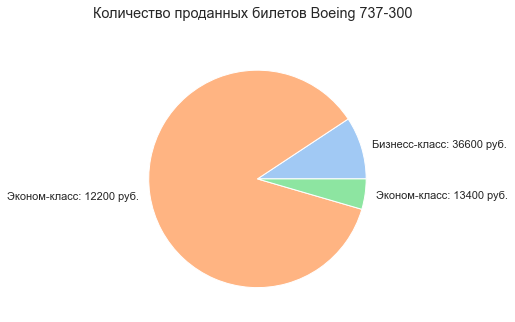

In [27]:
t_PG0252.plot(kind='pie', title = 'Количество проданных билетов Boeing 737-300', ylabel='', \
       labels=['Бизнесс-класс: 36600 руб.','Эконом-класс: 12200 руб.','Эконом-класс: 13400 руб.'], \
       figsize=(5,5), subplots=True, legend = False)
plt.show()

In [28]:
ticket_price_12000 = flight[flight.ticket_price == 12200.0][['flight_id', 'fl_month', 'seat_available']]
ticket_price_12000

,flight_id,fl_month,seat_available
12,136119,1.0,9B
13,136119,1.0,15D
14,136119,1.0,10D
15,136119,1.0,5A
16,136119,1.0,6E
...,...,...,...
8296,136486,2.0,4D
8297,136486,2.0,20E
8298,136486,2.0,21D
8299,136486,2.0,5F


In [29]:
ticket_price_12000.seat_available.unique()

array(['9B', '15D', '10D', '5A', '6E', '17A', '7B', '16F', '7E', '17D',
       '14E', '21C', '6D', '17F', '23F', '8D', '12D', '21F', '15B', '4E',
       '15E', '10C', '4B', '4F', '7F', '9C', '13F', '12A', '18A', '6A',
       '21A', '7C', '7A', '20F', '4C', '9F', '9D', '14F', '22F', '22A',
       '8E', '19B', '16E', '14B', '20E', '8C', '16C', '21D', '12C', '9E',
       '6B', '13D', '18E', '12B', '18C', '5E', '8A', '16B', '5B', '15F',
       '20B', '17C', '22B', '16D', '14D', '19C', '13B', '4D', '22E',
       '17E', '17B', '6F', '6C', '22C', '14A', '13C', '20D', '22D', '5F',
       '7D', '5D', '13E', '20C', '23B', '23E', '13A', '18D', '10E', '23A',
       '19F', '5C', '18F', '19D', '16A', '19E', '8B', '15C', '23D', '20A',
       '21B', '14C', '12F', '10B', '8F', '12E', '15A', '18B', '23C', '4A',
       '19A', '21E', '9A'], dtype=object)

In [30]:
ticket_price_13400 = flight[flight.ticket_price == 13400.0][['flight_id', 'fl_month', 'seat_available']]
ticket_price_13400

,flight_id,fl_month,seat_available
18,136119,1.0,11E
19,136119,1.0,11A
44,136119,1.0,11C
95,136119,1.0,11B
99,136119,1.0,11F
...,...,...,...
8173,136479,2.0,11D
8212,136486,2.0,11D
8220,136486,2.0,11A
8253,136486,2.0,11B


In [31]:
ticket_price_13400.seat_available.unique()

array(['11E', '11A', '11C', '11B', '11F', '11D'], dtype=object)

Предварительные выводы (Анапа-Москва):

1) Номер рейса PG0252 (Анапа-Москва) соответствует модели Boeing 737-300, \
2) Стоимость билета в Бизнес-классе составляет 36600 руб., \
3) Стоимость билета в Эконом-классе: для мест, начинающихся на 11*, стоимость составляет 13400 руб.,
для всех остальных - 12200 руб., \
4) Стоимость билета в феврале осталась на уровне января.

Изучим стоимость билетов по следующему направлению:

In [32]:
flight_no_PG0480 = flight[(flight.flight_no == 'PG0480') & 
                          (flight.ticket_price.isna() == False)]
flight_no_PG0480

,flight_id,flight_no,city_depart,city_arrive,scheduled_departure,scheduled_arrival,fl_month,flight_minute,model,class_available,seat_available,ticket_no,class_occupied,seat_occupied,ticket_price,fuel_price,fuel_per_hour,fl_day
8840,136571,PG0480,Anapa,Belgorod,2017-01-25 09:25:00+00:00,2017-01-25T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Business,3D,5432319274,Business,3D,18900.0,48893.30,1800,25
8841,136571,PG0480,Anapa,Belgorod,2017-01-25 09:25:00+00:00,2017-01-25T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Business,2C,5432319298,Business,2C,18900.0,48893.30,1800,25
8842,136571,PG0480,Anapa,Belgorod,2017-01-25 09:25:00+00:00,2017-01-25T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Business,1D,5432319443,Business,1D,18900.0,48893.30,1800,25
8843,136571,PG0480,Anapa,Belgorod,2017-01-25 09:25:00+00:00,2017-01-25T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Business,1A,5432319500,Business,1A,18900.0,48893.30,1800,25
8844,136571,PG0480,Anapa,Belgorod,2017-01-25 09:25:00+00:00,2017-01-25T10:15:00Z,1.0,50.0,Sukhoi Superjet-100,Business,1F,5432319562,Business,1F,18900.0,48893.30,1800,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14558,136956,PG0480,Anapa,Belgorod,2017-02-04 09:25:00+00:00,2017-02-04T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,4C,5432375738,Economy,4C,6300.0,46672.54,1800,4
14559,136956,PG0480,Anapa,Belgorod,2017-02-04 09:25:00+00:00,2017-02-04T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,13E,5432375772,Economy,13E,6300.0,46672.54,1800,4
14560,136956,PG0480,Anapa,Belgorod,2017-02-04 09:25:00+00:00,2017-02-04T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,14C,5432375774,Economy,14C,6300.0,46672.54,1800,4
14561,136956,PG0480,Anapa,Belgorod,2017-02-04 09:25:00+00:00,2017-02-04T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,6F,5432375784,Economy,6F,6900.0,46672.54,1800,4


In [33]:
tarif_PG0480 = pd.DataFrame(flight_no_PG0480.groupby(['model', 'class_available', 'ticket_price'])['ticket_price'].count())
tarif_PG0480

ticket_price
model               class_available ticket_price              
Sukhoi Superjet-100 Business        18900.0                653
                    Economy         6300.0                4392
                                    6900.0                 276

In [34]:
t_PG0480 = tarif_PG0480.unstack(0)

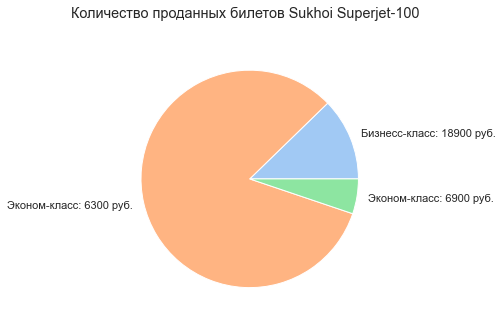

In [35]:
t_PG0480.plot(kind='pie', title = 'Количество проданных билетов Sukhoi Superjet-100', ylabel='', \
       labels=['Бизнесс-класс: 18900 руб.','Эконом-класс: 6300 руб.','Эконом-класс: 6900 руб.'], \
       figsize=(5,5), subplots=True, legend = False)
plt.show()

In [36]:
ticket_price_6300 = flight[flight.ticket_price == 6300.0][['flight_id', 'fl_month', 'seat_available']]
ticket_price_6300

,flight_id,fl_month,seat_available
8852,136571,1.0,12D
8853,136571,1.0,9E
8854,136571,1.0,19D
8856,136571,1.0,7D
8858,136571,1.0,19E
...,...,...,...
14557,136956,2.0,15F
14558,136956,2.0,4C
14559,136956,2.0,13E
14560,136956,2.0,14C


In [37]:
ticket_price_6300.seat_available.unique()

array(['12D', '9E', '19D', '7D', '19E', '16F', '17D', '11F', '17A', '20C',
       '15C', '12F', '5D', '4F', '13E', '10E', '9A', '10F', '19F', '16C',
       '18C', '19C', '18F', '20A', '15D', '20E', '20D', '8D', '8E', '5E',
       '5F', '15E', '11C', '10C', '7F', '7E', '13F', '13C', '11E', '15F',
       '17C', '5A', '12E', '16A', '14E', '13D', '12A', '16D', '14C', '8F',
       '10A', '4D', '10D', '4A', '9F', '17F', '20F', '19A', '8C', '9D',
       '11D', '11A', '14F', '16E', '18D', '7C', '9C', '8A', '4E', '18A',
       '13A', '15A', '7A', '12C', '4C', '14A', '17E', '18E', '5C', '14D'],
      dtype=object)

In [38]:
ticket_price_6900 = flight[flight.ticket_price == 6900.0][['flight_id', 'fl_month', 'seat_available']]
ticket_price_6900

,flight_id,fl_month,seat_available
8855,136571,1.0,6A
8857,136571,1.0,6C
8913,136571,1.0,6F
8926,136571,1.0,6E
8932,136571,1.0,6D
...,...,...,...
14500,136956,2.0,6C
14510,136956,2.0,6A
14511,136956,2.0,6D
14535,136956,2.0,6E


In [39]:
ticket_price_6900.seat_available.unique()

array(['6A', '6C', '6F', '6E', '6D'], dtype=object)

Предварительные выводы (Анапа-Белгород):

1) Номер рейса PG0480 (Анапа-Белгород) соответствует модели Sukhoi Superjet-100, \
2) Стоимость билета в Бизнес-классе составляет 18900 руб., \
3) Стоимость билета в Эконом-классе: для мест, начинающихся на 6*, стоимость составляет 6900 руб., для всех остальных - 6300 руб., \
4) Стоимость билета в феврале осталась на уровне января.

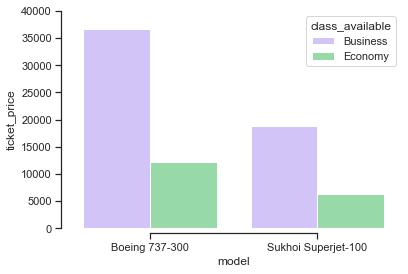

In [40]:
sns.set_theme(style="ticks", palette="pastel")
sns.barplot(x="model", y="ticket_price",
            hue="class_available", palette=["m", "g"],
            data=flight)
plt.ylim(0, 40000)
sns.despine(offset=5, trim=True)
plt.show()

Найдем доход от продажи билетов по каждому ID рейса.

In [41]:
flight_id_profit = flight.groupby(['flight_id'])[['ticket_price']].sum().sort_values(by = 'flight_id')
display(flight_id_profit)

,ticket_price
flight_id,
136119,1653000.0
136120,1605400.0
136122,1431000.0
136130,1556600.0
136131,1812800.0
...,...
136936,632400.0
136937,626100.0
136951,720600.0


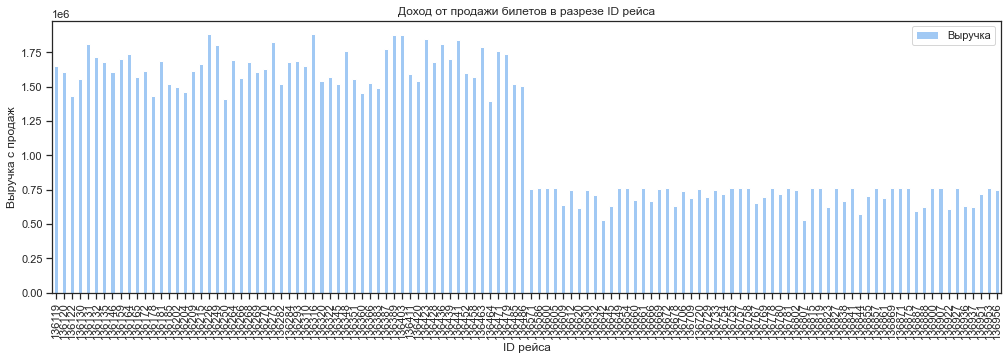

In [42]:
flight_id_profit.plot.bar(title='Доход от продажи билетов в разрезе ID рейса', \
                          figsize=(17,5), xlabel="ID рейса", ylabel="Выручка с продаж")
plt.legend(["Выручка"])
plt.show()

Далее найдем расходы на топливо по каждому ID рейса и создадим отдельный датафрейм 'flight_id_cost'

In [43]:
flight['fuel_cost'] = round((flight['fuel_price']*flight['fuel_per_hour']/1000)*(flight['flight_minute']/60), 2)

In [44]:
flight_id_cost = flight[['flight_id', 'flight_no', 'fl_month', 'fl_day', 'model', 'fuel_cost']].drop_duplicates()
display(flight_id_cost)

,flight_id,flight_no,fl_month,fl_day,model,fuel_cost
0,136119,PG0252,1.0,3,Boeing 737-300,211870.97
130,136122,PG0252,1.0,8,Boeing 737-300,211870.97
260,136131,PG0252,1.0,28,Boeing 737-300,211870.97
390,136159,PG0252,1.0,4,Boeing 737-300,211870.97
520,136164,PG0252,1.0,7,Boeing 737-300,211870.97
...,...,...,...,...,...,...
14078,136900,PG0480,2.0,1,Sukhoi Superjet-100,70008.81
14175,136922,PG0480,2.0,11,Sukhoi Superjet-100,70008.81
14272,136951,PG0480,2.0,2,Sukhoi Superjet-100,70008.81
14369,136953,PG0480,2.0,27,Sukhoi Superjet-100,70008.81


Создадим датасет 'profit_fact', содержащий данные по доходу от продажи билетов и расходу на топливо по каждому рейсу. Также создадим итоговый столбец 'profit', как разница между выручкой с продаж и расходами на топливо

In [45]:
profit_fact = flight_id_profit.merge(flight_id_cost, on = 'flight_id', how = 'inner')
profit_fact['profit'] = profit_fact['ticket_price'] - profit_fact['fuel_cost']
profit_fact

,flight_id,ticket_price,flight_no,fl_month,fl_day,model,fuel_cost,profit
0,136119,1653000.0,PG0252,1.0,3,Boeing 737-300,211870.97,1441129.03
1,136120,1605400.0,PG0252,2.0,24,Boeing 737-300,202247.67,1403152.33
2,136122,1431000.0,PG0252,1.0,8,Boeing 737-300,211870.97,1219129.03
3,136130,1556600.0,PG0252,2.0,13,Boeing 737-300,202247.67,1354352.33
4,136131,1812800.0,PG0252,1.0,28,Boeing 737-300,211870.97,1600929.03
...,...,...,...,...,...,...,...,...
113,136936,632400.0,PG0480,1.0,2,Sukhoi Superjet-100,73339.95,559060.05
114,136937,626100.0,PG0480,1.0,3,Sukhoi Superjet-100,73339.95,552760.05
115,136951,720600.0,PG0480,2.0,2,Sukhoi Superjet-100,70008.81,650591.19
116,136953,765300.0,PG0480,2.0,27,Sukhoi Superjet-100,70008.81,695291.19


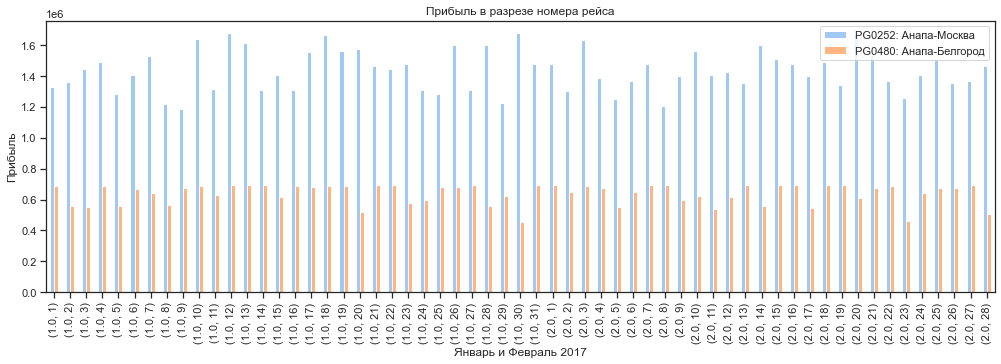

In [46]:
profit_fact.pivot_table(values = ['profit'], 
               index = ['flight_no', 'fl_month', 'fl_day'], 
               aggfunc = 'sum').unstack(0).plot(title='Прибыль в разрезе номера рейса', \
                                                kind = 'bar', figsize=(17,5), xlabel="Январь и Февраль 2017", \
                                                ylabel="Прибыль")
plt.legend(['PG0252: Анапа-Москва', 'PG0480: Анапа-Белгород'])
plt.show()

Можно сделать вывод, что убыточных рейсов по данным направлениям нет, однако  существуют малоприбыльные.

Теперь проанализируем, сколько каждый рейс недополучил прибыли (на основании данных о непроданных местах). \
Преобразуем датасет, создадим вспомогательный для анализа пустых мест (заменим значения Nan на 0 для удобства)

In [47]:
seat_empty = flight.loc[flight['seat_occupied'].isna() == True]
seat_empty.loc[:, ['class_occupied']] = seat_empty['class_occupied'].fillna(0)
seat_empty.loc[:, ['seat_occupied']] = seat_empty['seat_occupied'].fillna(0)
seat_empty.loc[:, ['ticket_price']] = seat_empty['ticket_price'].fillna(0)
seat_empty.loc[:, ['ticket_no']] = seat_empty['ticket_no'].replace('nan', 0)
seat_empty

C:\Users\Sony\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,flight_id,flight_no,city_depart,city_arrive,scheduled_departure,scheduled_arrival,fl_month,flight_minute,model,class_available,seat_available,ticket_no,class_occupied,seat_occupied,ticket_price,fuel_price,fuel_per_hour,fl_day,fuel_cost
11,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Business,3F,0,0,0,0.0,48893.30,2600,3,211870.97
114,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,20A,0,0,0,0.0,48893.30,2600,3,211870.97
115,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,12F,0,0,0,0.0,48893.30,2600,3,211870.97
116,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,8F,0,0,0,0.0,48893.30,2600,3,211870.97
117,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,12E,0,0,0,0.0,48893.30,2600,3,211870.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14365,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,6E,0,0,0,0.0,46672.54,1800,2,70008.81
14366,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,14D,0,0,0,0.0,46672.54,1800,2,70008.81
14367,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,15A,0,0,0,0.0,46672.54,1800,2,70008.81
14368,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,17A,0,0,0,0.0,46672.54,1800,2,70008.81


In [48]:
seat_empty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1398 entries, 11 to 14477
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   flight_id            1398 non-null   int64              
 1   flight_no            1398 non-null   object             
 2   city_depart          1398 non-null   object             
 3   city_arrive          1398 non-null   object             
 4   scheduled_departure  1398 non-null   datetime64[ns, UTC]
 5   scheduled_arrival    1398 non-null   object             
 6   fl_month             1398 non-null   float64            
 7   flight_minute        1398 non-null   float64            
 8   model                1398 non-null   object             
 9   class_available      1398 non-null   object             
 10  seat_available       1398 non-null   object             
 11  ticket_no            1398 non-null   int64              
 12  class_occupied    

Воспользуемся полученными ранее данными о стоимости билетов:

1) Boeing 737-300: 'Business' = 36600 руб., 'Economy' = 12200 руб., 'Economy' (места 11*) = 13400 руб., \
2) Sukhoi Superjet-100: 'Business' = 18900 руб., 'Economy' = 6300 руб., 'Economy' (места 6*) = 6900 руб.

In [49]:
seat_empty['ticket_price_loss'] = seat_empty['ticket_price']
seat_empty['ticket_price_loss'] = seat_empty.apply(lambda row: fill_ticket_price(row), axis=1)

<ipython-input-49-d8372aa77ff4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seat_empty['ticket_price_loss'] = seat_empty['ticket_price']
<ipython-input-49-d8372aa77ff4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seat_empty['ticket_price_loss'] = seat_empty.apply(lambda row: fill_ticket_price(row), axis=1)


In [50]:
seat_empty

,flight_id,flight_no,city_depart,city_arrive,scheduled_departure,scheduled_arrival,fl_month,flight_minute,model,class_available,seat_available,ticket_no,class_occupied,seat_occupied,ticket_price,fuel_price,fuel_per_hour,fl_day,fuel_cost,ticket_price_loss
11,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Business,3F,0,0,0,0.0,48893.30,2600,3,211870.97,36600
114,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,20A,0,0,0,0.0,48893.30,2600,3,211870.97,12200
115,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,12F,0,0,0,0.0,48893.30,2600,3,211870.97,12200
116,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,8F,0,0,0,0.0,48893.30,2600,3,211870.97,12200
117,136119,PG0252,Anapa,Moscow,2017-01-03 10:05:00+00:00,2017-01-03T11:45:00Z,1.0,100.0,Boeing 737-300,Economy,12E,0,0,0,0.0,48893.30,2600,3,211870.97,12200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14365,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,6E,0,0,0,0.0,46672.54,1800,2,70008.81,6900
14366,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,14D,0,0,0,0.0,46672.54,1800,2,70008.81,6300
14367,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,15A,0,0,0,0.0,46672.54,1800,2,70008.81,6300
14368,136951,PG0480,Anapa,Belgorod,2017-02-02 09:25:00+00:00,2017-02-02T10:15:00Z,2.0,50.0,Sukhoi Superjet-100,Economy,17A,0,0,0,0.0,46672.54,1800,2,70008.81,6300


Найдем доход от продажи билетов по каждому ID рейса по пустым местам:

In [51]:
flight_id_loss_profit = seat_empty.groupby(['flight_id'])[['ticket_price_loss']].sum()
flight_id_loss_profit.sort_values(by = 'flight_id')

,ticket_price_loss
flight_id,
136119,233000
136120,280600
136122,455000
136130,329400
136131,73200
...,...
136922,157500
136936,132900
136937,139200


Объединим два датасета с данными о выручке с продаж и упущенной выгоде в один 'profit_total':

In [52]:
profit_total = profit_fact.merge(flight_id_loss_profit, on = 'flight_id', how = 'left')
profit_total

,flight_id,ticket_price,flight_no,fl_month,fl_day,model,fuel_cost,profit,ticket_price_loss
0,136119,1653000.0,PG0252,1.0,3,Boeing 737-300,211870.97,1441129.03,233000.0
1,136120,1605400.0,PG0252,2.0,24,Boeing 737-300,202247.67,1403152.33,280600.0
2,136122,1431000.0,PG0252,1.0,8,Boeing 737-300,211870.97,1219129.03,455000.0
3,136130,1556600.0,PG0252,2.0,13,Boeing 737-300,202247.67,1354352.33,329400.0
4,136131,1812800.0,PG0252,1.0,28,Boeing 737-300,211870.97,1600929.03,73200.0
...,...,...,...,...,...,...,...,...,...
113,136936,632400.0,PG0480,1.0,2,Sukhoi Superjet-100,73339.95,559060.05,132900.0
114,136937,626100.0,PG0480,1.0,3,Sukhoi Superjet-100,73339.95,552760.05,139200.0
115,136951,720600.0,PG0480,2.0,2,Sukhoi Superjet-100,70008.81,650591.19,44700.0
116,136953,765300.0,PG0480,2.0,27,Sukhoi Superjet-100,70008.81,695291.19,NaN


In [53]:
# заменим пропуски на 0, т.к. данных по упущенной выгоде нет для данных id рейсов
profit_total.ticket_price_loss = profit_total.ticket_price_loss.fillna(0)

In [54]:
# создадим столбец 'profit_max' - максимально возможная прибыль на рейсе
profit_total['profit_max'] = profit_total['profit'] + profit_total['ticket_price_loss']

In [55]:
# 75% от максимально возможной прибыли, как граница для оценки малоприбыльности рейса - столбец 'profit_0_75'
profit_total['profit_0_75'] = (profit_total['profit_max']*0.75).apply(lambda x: "{:.2f}".format(x)).astype(float)

Далее выведем список малоприбыльных рейсов 'flight_unprofit', выручка с продаж у которых ниже 75%-го уровня от максимально возможной прибыли.

In [56]:
flight_unprofit = profit_total[profit_total.profit < profit_total.profit_0_75\
                              ][['flight_id', 'flight_no', 'profit', 'profit_max', 'profit_0_75']]
flight_unprofit

,flight_id,flight_no,profit,profit_max,profit_0_75
2,136122,PG0252,1219129.03,1674129.03,1255596.77
12,136178,PG0252,1222729.03,1674129.03,1255596.77
16,136204,PG0252,1255552.33,1683752.33,1262814.25
21,136250,PG0252,1205552.33,1683752.33,1262814.25
38,136360,PG0252,1253152.33,1683752.33,1262814.25
54,136464,PG0252,1186129.03,1674129.03,1255596.77
68,136642,PG0480,457660.05,691960.05,518970.04
93,136807,PG0480,460991.19,695291.19,521468.39
100,136844,PG0480,505091.19,695291.19,521468.39


Создадим датафрейм 'flight_small' из 'flight' и объединим его с 'flight_unprofit' для дальнейшего анализа

In [57]:
flight_small = flight[['flight_id', 'city_depart', 'city_arrive', 'scheduled_departure',
                      'scheduled_arrival', 'fl_month', 'fl_day', 'model']]

In [58]:
flight_small = flight_unprofit.merge(flight_small, on = 'flight_id', how = 'inner').drop_duplicates()
flight_small

,flight_id,flight_no,profit,profit_max,profit_0_75,city_depart,city_arrive,scheduled_departure,scheduled_arrival,fl_month,fl_day,model
0,136122,PG0252,1219129.03,1674129.03,1255596.77,Anapa,Moscow,2017-01-08 10:05:00+00:00,2017-01-08T11:45:00Z,1.0,8,Boeing 737-300
130,136178,PG0252,1222729.03,1674129.03,1255596.77,Anapa,Moscow,2017-01-29 10:05:00+00:00,2017-01-29T11:45:00Z,1.0,29,Boeing 737-300
260,136204,PG0252,1255552.33,1683752.33,1262814.25,Anapa,Moscow,2017-02-23 10:05:00+00:00,2017-02-23T11:45:00Z,2.0,23,Boeing 737-300
390,136250,PG0252,1205552.33,1683752.33,1262814.25,Anapa,Moscow,2017-02-08 10:05:00+00:00,2017-02-08T11:45:00Z,2.0,8,Boeing 737-300
520,136360,PG0252,1253152.33,1683752.33,1262814.25,Anapa,Moscow,2017-02-05 10:05:00+00:00,2017-02-05T11:45:00Z,2.0,5,Boeing 737-300
650,136464,PG0252,1186129.03,1674129.03,1255596.77,Anapa,Moscow,2017-01-09 10:05:00+00:00,2017-01-09T11:45:00Z,1.0,9,Boeing 737-300
780,136642,PG0480,457660.05,691960.05,518970.04,Anapa,Belgorod,2017-01-30 09:25:00+00:00,2017-01-30T10:15:00Z,1.0,30,Sukhoi Superjet-100
877,136807,PG0480,460991.19,695291.19,521468.39,Anapa,Belgorod,2017-02-23 09:25:00+00:00,2017-02-23T10:15:00Z,2.0,23,Sukhoi Superjet-100
974,136844,PG0480,505091.19,695291.19,521468.39,Anapa,Belgorod,2017-02-28 09:25:00+00:00,2017-02-28T10:15:00Z,2.0,28,Sukhoi Superjet-100


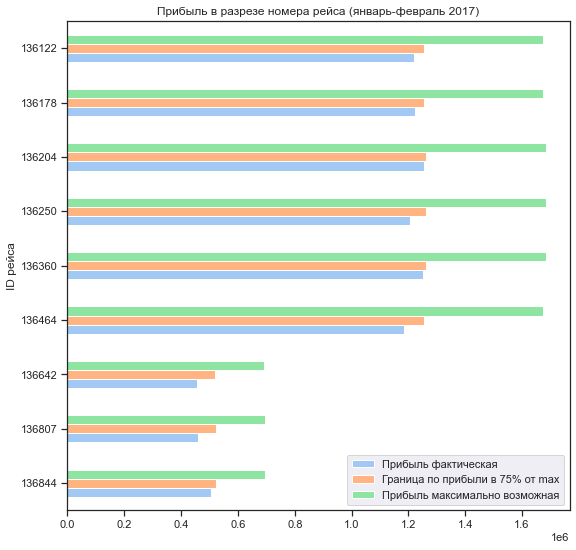

In [59]:
flight_small[['flight_id', 'profit', 'profit_0_75', 'profit_max' \
             ]].set_index('flight_id').sort_index(ascending=False\
                                                 ).plot.barh(figsize=(9, 9),\
                                                             title='Прибыль в разрезе номера рейса (январь-февраль 2017)',\
                                                             ylabel="Прибыль", xlabel="ID рейса")
sns.set_theme(palette="pastel")
plt.subplots_adjust(hspace=0.35)
plt.legend(["Прибыль фактическая", "Граница по прибыли в 75% от max", "Прибыль максимально возможная"])
plt.show()

Мы получили список малоприбыльных рейсов, выручка с продаж у которых ниже 75%-го уровня от максимально возможной прибыли. 

Ниже представлен график отобранных ранее малоприбыльных рейсов, в котором содержится информация по дню и месяцу вылета, а также модели самолета и номеру ID.

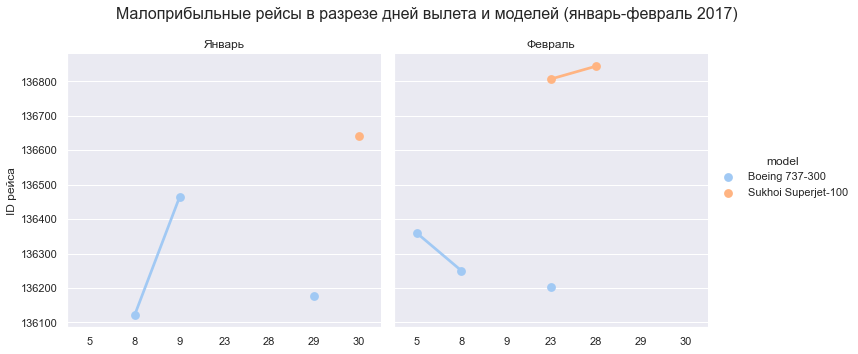

In [60]:
g = sns.catplot(x="fl_day", y="flight_id", hue="model", col="fl_month",\
            kind="point", data=flight_small)
(g.set_axis_labels("", "ID рейса").set_titles("Январь"))    
plt.title('Февраль')   
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Малоприбыльные рейсы в разрезе дней вылета и моделей (январь-февраль 2017)', fontsize=16)       
plt.show()

### Подведем итоги:
В результате EDA были получены следующие выводы:

1) Из 127-ми рейсов, совершенных зимой 2017 года из г. Анапа, малоприбыльными (выручка с продаж у которых ниже 75%-го уровня от максимально возможной прибыли) оказались всего 9 рейсов;\
2) Данные рейсы летают по 2-м направлениям: Анапа-Москва и Анапа-Белгород;\
3) Был получен следующий список малоприбыльных рейсов по направлениям:
1. Анапа-Москва - (136122, 136178, 136204, 136250, 136360, 136464),
2. Анапа-Белгород - (136642, 136807, 136844);

4) Представлено 2 модели самолетов по указанным направлениям: Boeing 737-300 (Анапа-Москва) и Sukhoi Superjet-100 (Анапа-Белгород);\
5) На каждом самолете представлено всего 2 класса обслуживания: Бизнес и Эконом;\
6) Количество доступных мест для каждой модели:
1. Boeing 737-300 - 12 мест в Бизнес-классе, 118 мест в Эконом-классе,
2. Sukhoi Superjet-100 - 12 мест в Бизнес-классе, 85 мест в Эконом-классе;

7) Были получены следующие данные по стоимости билетов:
1. Boeing 737-300: 'Business' = 36600 руб., 'Economy' = 12200 руб., 'Economy' (места 11) = 13400 руб.,
2. Sukhoi Superjet-100: 'Business' = 18900 руб., 'Economy' = 6300 руб., 'Economy' (места 6) = 6900 руб;

8) Стоимость билета в феврале осталась на уровне января;\
9) Можно заметить, что в определенные дни борт самолета Boeing 737-300 совершал два полета (предоставляя 260 мест), однако заполняемость в разрезе каждого дня не выходила за рамки 150 мест. Возможно, что именно в эти дни один из рейсов мог оказаться малоприбыльным.

На основании полученной информации, возможны следующие пути повышения прибыльности рейсов по данным направлениям:
1) Оставить один рейс на определенные графиком вылета дни (в связи с низкой заполняемостью);\
2) Повысить стоимость билета в Эконом-класс в праздничные дни (+-1 день);\
3) В качестве эксперимента понизить стоимость билета в Бизнес-класс в праздничные дни (+-1 день). Основная выручка от продаж приходится на пассажиров Эконом-класса.